In [1]:
# 使用models模块创建并训练神经网络模型
import pandas as pd
import scutquant.scutquant as q
from scutquant import alpha, report, executor

In [2]:
df = pd.read_csv("D:/Desktop/data.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df["mean_price"] = df["amount"] / df["vol"] * 10  # 每支股票在当天的交易均价
df.set_index(["datetime", "ts_code"], inplace=True)
df.index.names = ["datetime", "instrument"]
df

open    high     low   close  pre_close  change  \
datetime   instrument                                                      
2006-01-04 000001.SZ     6.13    6.33    6.12    6.28       6.14    0.14   
           000002.SZ     4.40    4.67    4.40    4.66       4.31    0.35   
           000012.SZ     4.70    4.75    4.55    4.70       4.62    0.08   
           000016.SZ     3.52    3.58    3.52    3.57       3.52    0.05   
           000021.SZ     7.99    8.40    7.99    8.32       8.00    0.32   
...                       ...     ...     ...     ...        ...     ...   
2022-12-30 688363.SH   136.00  137.00  131.50  135.28     135.49   -0.21   
           688396.SH    53.06   53.40   52.49   52.65      52.87   -0.22   
           688561.SH    65.49   67.88   64.85   65.77      65.46    0.31   
           688599.SH    63.31   64.56   62.31   63.76      63.20    0.56   
           688981.SH    41.01   41.35   41.01   41.14      40.89    0.25   

                       pct_chg        vol       amount  mean_price  
datetime   instrument                                               
2006-01-04 000001.SZ    2.2800  154450.68   96989.0066    6.279610  
           000002.SZ    8.1200  389310.43  175187.0657    4.499933  
           000012.SZ    1.7300   40399.61   18863.8625    4.669318  
           000016.SZ    1.4200   14426.65    5131.8793    3.557222  
           000021.SZ    4.0000   33526.60   27657.1708    8.249322  
...                        ...        ...          ...         ...  
2022-12-30 688363.SH   -0.1550   29951.60  401624.1560  134.091052  
           688396.SH   -0.4161   23401.54  123568.2880   52.803486  
           688561.SH    0.4736   22567.89  149379.0770   66.190981  
           688599.SH    0.8861  109144.36  695759.9350   63.746760  
           688981.SH    0.6114   60396.11  248594.8820   41.160744  

[1199445 rows x 10 columns]

In [3]:
# 构造目标值, 并按照-10% 和10%截断(因为有涨跌停限制)
df["label"] = df["pct_chg"].groupby("instrument").shift(-2)
df = df.dropna()
df["label"].describe()

count    1.197673e+06
mean     5.759776e-02
std      2.858067e+00
min     -4.650000e+01
25%     -1.330000e+00
50%      0.000000e+00
75%      1.370000e+00
max      1.249400e+02
Name: label, dtype: float64

In [4]:
kwargs = {
    "data": df,
    "open": "open",
    "close": "close",
    "high": "high",
    "low": "low",
    "volume": "vol",
    "amount": "amount",
}
X = alpha.make_factors(kwargs=kwargs)
X = pd.concat([X, df[["label"]]], axis=1)
X = X.dropna()
X

time used: 106.25311279296875


DIF       DEA    RET1_1    RET2_1    RET1_2  \
datetime   instrument                                                     
2006-01-17 000001.SZ  -0.024902 -0.025264  0.008210  0.746032 -0.011272   
           000002.SZ  -0.024902 -0.025264  0.027778  0.940476 -0.002247   
           000012.SZ  -0.024902 -0.025264  0.000000  0.484127 -0.051282   
           000016.SZ  -0.024902 -0.025264  0.002625  0.555556 -0.010363   
           000021.SZ  -0.024902 -0.025264  0.005821  0.670635 -0.018182   
...                         ...       ...       ...       ...       ...   
2022-12-28 688363.SH   4.732139  3.689427 -0.014494  0.245614  0.046560   
           688396.SH   0.072127  0.480778 -0.013770  0.266667  0.000566   
           688561.SH   0.842230  0.673733 -0.021464  0.126316 -0.030424   
           688599.SH  -1.572494 -2.529311  0.039960  0.992982  0.056604   
           688981.SH   0.029167  0.184851 -0.013983  0.256140 -0.012793   

                         RET2_2    RET1_3    RET2_3    RET1_4    RET2_4  ...  \
datetime   instrument                                                    ...   
2006-01-17 000001.SZ   0.638889 -0.022293  0.520000 -0.014446  0.419355  ...   
           000002.SZ   0.789683 -0.041037  0.220000 -0.036876  0.145161  ...   
           000012.SZ   0.065476 -0.049541  0.112000 -0.001927  0.576613  ...   
           000016.SZ   0.670635 -0.002611  0.740000  0.013263  0.733871  ...   
           000021.SZ   0.539683 -0.029213  0.416000 -0.011442  0.447581  ...   
...                         ...       ...       ...       ...       ...  ...   
2022-12-28 688363.SH   0.933333  0.047447  0.880702  0.040554  0.866667  ...   
           688396.SH   0.417544  0.009716  0.515789 -0.012116  0.175439  ...   
           688561.SH   0.049123 -0.022484  0.052632  0.053772  0.912281  ...   
           688599.SH   0.961404  0.163852  0.996491  0.131926  0.996491  ...   
           688981.SH   0.185965 -0.003897  0.245614 -0.004139  0.284211  ...   

                       CORRCV10  CORRCV20  CORRCV30  CORRCV60   AMOUNT5  \
datetime   instrument                                                     
2006-01-17 000001.SZ   0.250344  0.259315  0.263750  0.264286  4.004864   
           000002.SZ   0.250344  0.259315  0.263750  0.264286  1.137970   
           000012.SZ   0.250344  0.259315  0.263750  0.264286  1.931408   
           000016.SZ   0.250344  0.259315  0.263750  0.264286  1.419808   
           000021.SZ   0.250344  0.259315  0.263750  0.264286  1.148783   
...                         ...       ...       ...       ...       ...   
2022-12-28 688363.SH   0.652414  0.628132  0.571650  0.136695  0.391778   
           688396.SH  -0.029898  0.266452  0.149417  0.379746  1.674625   
           688561.SH   0.653220  0.671022  0.580834  0.571083  0.494056   
           688599.SH   0.653162 -0.176020 -0.127618  0.027113  0.528563   
           688981.SH   0.365318  0.522244  0.458187  0.507671  1.126837   

                       AMOUNT10  AMOUNT20  AMOUNT30  AMOUNT60   label  
datetime   instrument                                                  
2006-01-17 000001.SZ   1.279995  1.372671  1.435125  1.555240  0.8000  
           000002.SZ   1.279995  1.372671  1.435125  1.555240  1.3200  
           000012.SZ   1.279995  1.372671  1.435125  1.555240  5.8900  
           000016.SZ   1.279995  1.372671  1.435125  1.555240 -1.0200  
           000021.SZ   1.279995  1.372671  1.435125  1.555240 -0.3200  
...                         ...       ...       ...       ...     ...  
2022-12-28 688363.SH   0.947322  0.719363  1.316014  0.427300 -0.1550  
           688396.SH   4.719745  1.218943  2.626182  1.643164 -0.4161  
           688561.SH   1.735394  1.894400  1.826660  1.045160  0.4736  
           688599.SH   0.575414  0.813492  0.810529  0.576380  0.8861  
           688981.SH   5.155468  1.256573  3.713760  0.867828  0.6114  

[1186035 rows x 176 columns]

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1186035 entries, (Timestamp('2006-01-17 00:00:00'), '000001.SZ') to (Timestamp('2022-12-28 00:00:00'), '688981.SH')
Columns: 176 entries, DIF to label
dtypes: float64(176)
memory usage: 1.6+ GB
None
X_mis= 0.0
clean dataset done 

split data done 

label norm done 

The distribution of y_train:


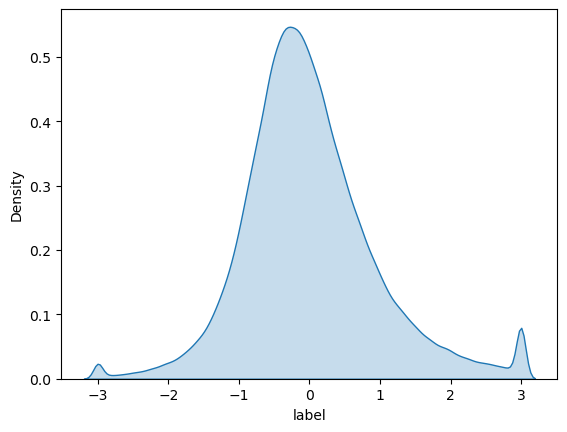

The distribution of y_valid:


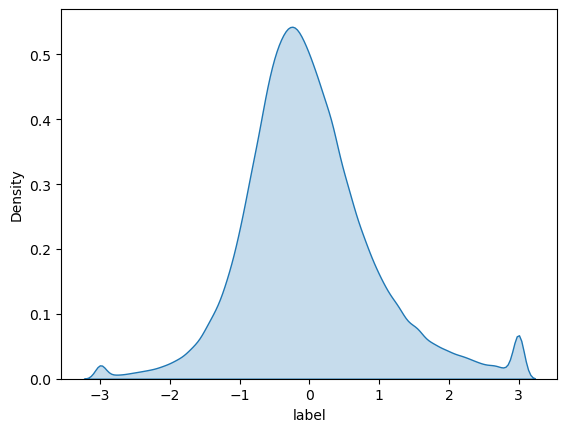

The distribution of y_test:


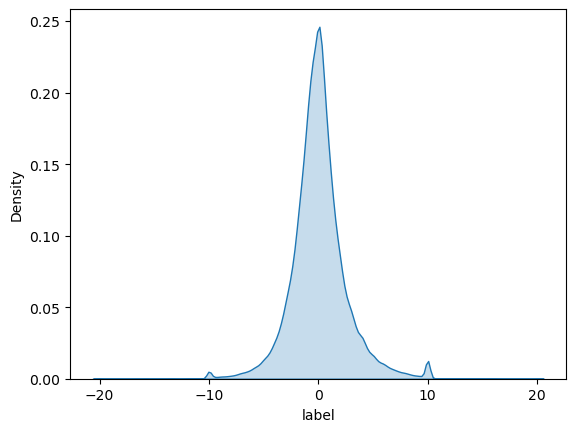

norm data done 

all works done 



In [5]:
split_params = {
    "test_start_date": "2019-01-01",
    "split_method": "group_split",
    "split_kwargs":{
        "train": 0.7,
        "valid": 0.3
    }
}

# 从训练集中按7：3的比例随机拆分出验证集, 并在截面上进行标准化
result = q.auto_process(X, "label", groupby="instrument", split_params=split_params, select=False, orth=False)

X_train, y_train, X_valid, y_valid = result["X_train"], result["y_train"], result["X_valid"], result["y_valid"]
X_test, y_test, ymean, ystd = result["X_test"], result["y_test"], result["ymean"], result["ystd"]

In [6]:
from scutquant import models

cnn = models.CNN()
cnn.fit(X_train, y_train, X_valid, y_valid)

pred = cnn.predict(X_test)
pred = pd.DataFrame(pred, columns=["predict"], index=X_test.index)
pred["predict"] += ymean.groupby("datetime").shift(2).fillna(0.0002)
pred["predict"] *= ystd.groupby("datetime").shift(2).fillna(0.0189)

pred.describe()

Epoch 1/10
2422/2422 [==============================] - 79s 32ms/step - loss: 0.9467 - mae: 0.7255 - mape: 2276.2317 - val_loss: 0.9045 - val_mae: 0.7100 - val_mape: 568.1694
Epoch 2/10
2422/2422 [==============================] - 74s 31ms/step - loss: 0.9036 - mae: 0.7092 - mape: 2385.3142 - val_loss: 0.9082 - val_mae: 0.7129 - val_mape: 897.1361
Epoch 3/10
2422/2422 [==============================] - 79s 33ms/step - loss: 0.8941 - mae: 0.7056 - mape: 1998.0586 - val_loss: 0.8860 - val_mae: 0.7007 - val_mape: 430.6793
Epoch 4/10
2422/2422 [==============================] - 74s 31ms/step - loss: 0.8873 - mae: 0.7029 - mape: 1713.1598 - val_loss: 0.8816 - val_mae: 0.7010 - val_mape: 393.2076
Epoch 5/10
2422/2422 [==============================] - 73s 30ms/step - loss: 0.8823 - mae: 0.7007 - mape: 1035.9167 - val_loss: 0.8793 - val_mae: 0.6975 - val_mape: 554.8331
Epoch 6/10
2422/2422 [==============================] - 74s 31ms/step - loss: 0.8804 - mae: 0.7000 - mape: 1174.3225 - val_lo

,predict
count,287857.000000
mean,-0.000745
std,0.001770
min,-0.013766
25%,-0.001765
50%,-0.000728
75%,0.000289
max,0.012649


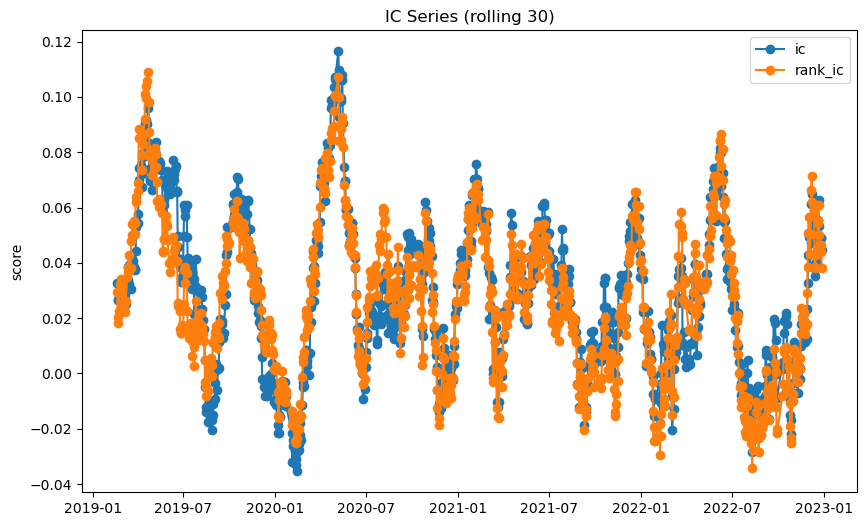

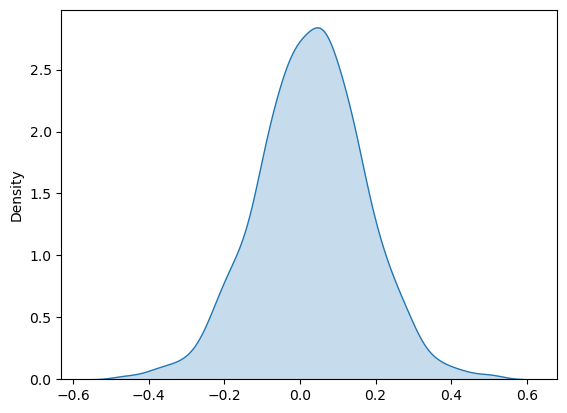

ic= 0.028421520068308708 icir= 0.19930242380721583 rank_ic= 0.026763102780739415 rank_icir= 0.18923912795956788


0.025904084007927788

In [7]:
# 使用IC评判拟合优度
ic, icir, rank_ic, rank_icir = q.ic_ana(pred, y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = q.pearson_corr(pred.values, y_test)
r[0]

In [8]:
model = cnn.model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 56, 32)            320       
                                                                 
 batch_normalization (BatchN  (None, 56, 32)           128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 55, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 17, 64)            14400     
                                                                 
 batch_normalization_1 (Batc  (None, 17, 64)           256       
 hNormalization)                                                 
                                                        

Accuracy of Prediction: 0.5287766655184531


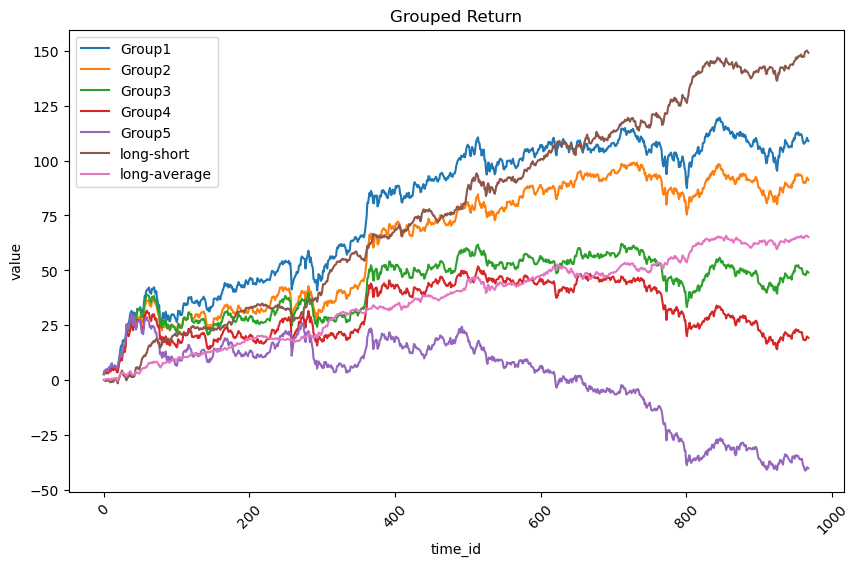

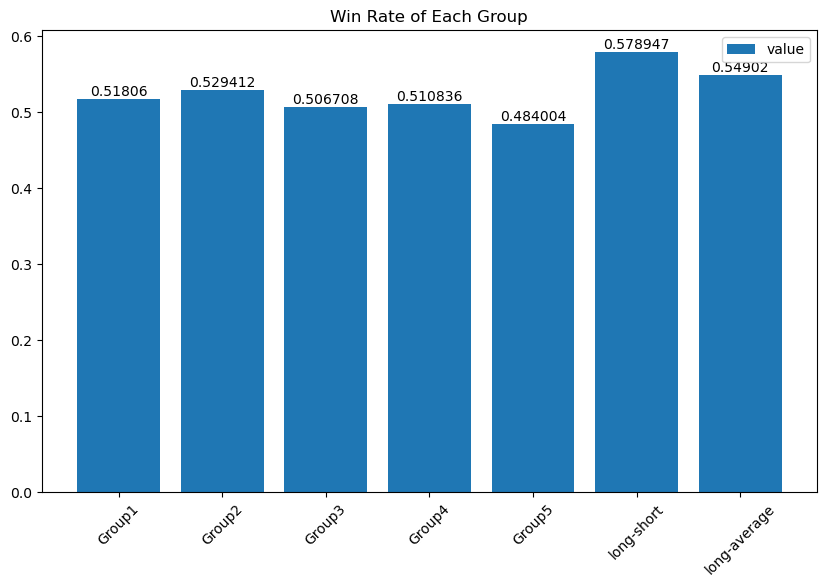

In [9]:
df_test = df[df.index.get_level_values(0) >= "2019-01-01"]
pred = executor.prepare(pred, df_test, price='mean_price', volume='vol')
report.group_return_ana(pred, y_test)

In [10]:
backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "SigmaStrategy",  # 做多预测值前20%股票, 做空后20%的股票. 自动平仓
        "kwargs": {
            "sigma": 1, 
            "auto_offset": False,
            "offset_freq": 2, # 应为delta_t + 1, 例如目标值是close_-2 / close_-1 - 1, 则delta_t = 1
            "buy_only": False,  # =True时，只做多不做空(在A股做空有一定的难度)
            "short_volume": 500, # 融券做空的数量
            "risk_degree": 0.95,  # 将风险度控制在这个数，如果超过了就按比例减持股票直到风险度小于等于它为止
            "unit": None,  # 由于数据已经是以手为单位, 故无需二次处理
            "max_volume": 0.05  # 手数随可用资金而改变，最大不会超过股票当天成交量的1%(例如T+1时下单，下单手数不会超过T时成交量的1%)
        }
    },
    "account": None, # 使用默认账户, 即初始资金为1亿, 无底仓 (注意策略容量！)
    "trade_params": {
        "cost_buy": 0.0015,  # 佣金加上印花税
        "cost_sell": 0.0015,  
        "min_cost": 5,
    }
}
generator, strategy, account, trade_params = backtest["generator"], backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(generator, strategy, account, trade_params)
exe.execute(data=pred, verbose=0)  # verbose=1时，按时间输出买卖指令

Annualized Return: 0.14862012497380594
Annualized Volatility: 0.46766179222567505
Annualized Return(Benchmark): 0.07903465509941188
Annualized Volatility(Benchmark): 0.33918455897903604 

Cumulative Rate of Return: 0.7036982117780144
Cumulative Rate of Return(Benchmark): 0.3397659986073198
Cumulative Excess Rate of Return: 0.3639322131706946 

Max Drawdown: -0.4518518202023134
Max Drawdown(Benchmark): -0.5464988056952735
Max Drawdown(Excess Return): -0.13583350583972797 

Sharpe Ratio: 2.2749883676607996
Sortino Ratio: 1.066684698452474
Information Ratio: 0.5365600785028469 

Beta: 1.248229650872593
Alpha: 0.02502865768862672
Epsilon: 0.10129755702168557
Profitable Days(%): 0.9153766769865841


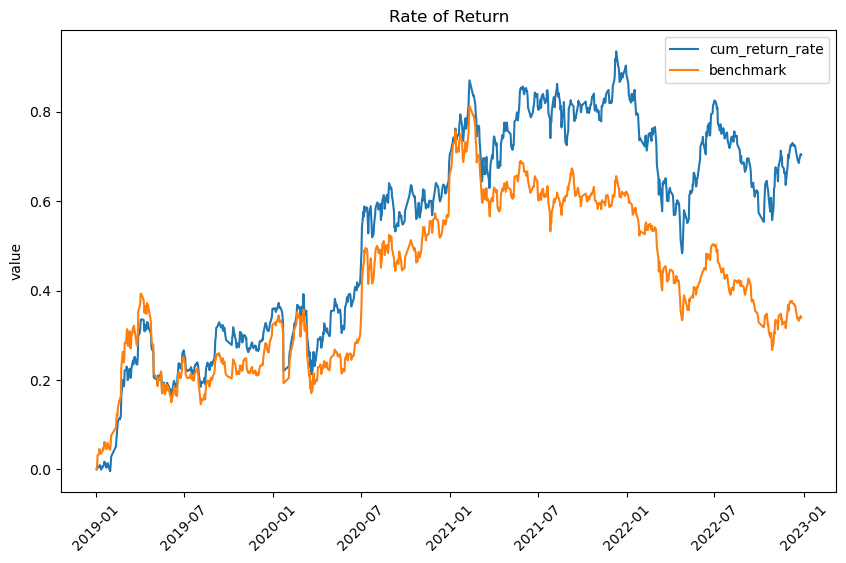

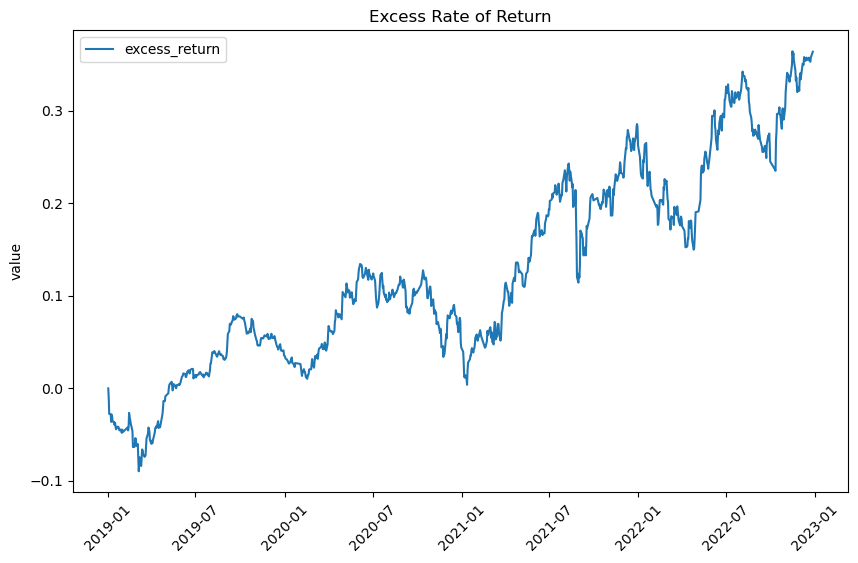

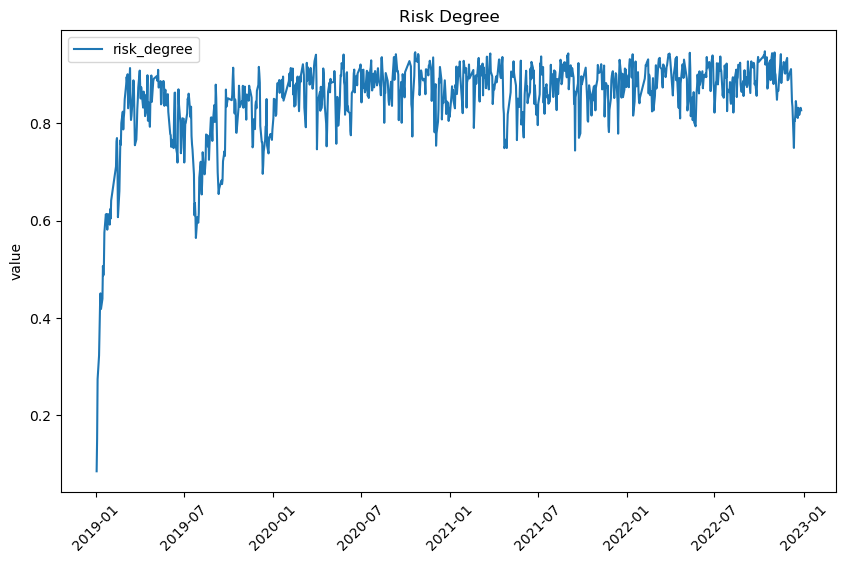

In [11]:
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=365, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节

In [12]:
model.save("cnn")

INFO:tensorflow:Assets written to: cnn\assets


INFO:tensorflow:Assets written to: cnn\assets
